In [1]:
import netCDF4 as nc

PATH_FILE = '/data/manon/MasterThesis/NOAA/gdp_v2.00.nc'

ds = nc.Dataset(PATH_FILE)

In [2]:
ds.variables['time'].units

'seconds since 1970-01-01'

In [3]:
lats = ds.variables['latitude']
lats = lats[:].data
lons = ds.variables['longitude']
lons = lons[:].data
time = ds.variables['time']
time = time[:].data
ids = ds.variables['ids'] #indices de la trajectoire à laquelle appartient chaque pt
ids = ids[:].data

In [4]:
import numpy as np
len(np.unique(ids))

17324

In [5]:
import pandas as pd

df = pd.DataFrame(data={'latitude':lats, 'longitude':lons, 'time':time,'ids':ids})
df.head()

,latitude,longitude,time,ids
0,14.74677,-17.74345,1331848800,101143
1,14.75717,-17.74526,1331852400,101143
2,14.76780,-17.74375,1331856000,101143
3,14.77795,-17.74173,1331859600,101143
4,14.78923,-17.73838,1331863200,101143


In [6]:
from datetime import datetime, timedelta

def convert_seconds_into_hours_since_2000(seconds):
    ref1970 = datetime(1970,1,1,0,0,0)
    ref2000 = datetime(2000,1,1,0,0,0)
    century_diff = ref2000-ref1970
    sec2000 = seconds - century_diff.total_seconds()
    return sec2000/3600 # convert in h

def convert_date(nseconds):
    # returns day but not hour
    reference = datetime(1970,1,1,0,0,0)
    time_delta = timedelta(seconds=nseconds)
    date = reference + time_delta
    return date

In [7]:
df['time'] = df['time'].apply(lambda x: convert_seconds_into_hours_since_2000(x))
#df['date'] = df['time'].apply(lambda x: convert_date(x))

In [8]:
import os
from tqdm import tqdm

grouped = df.groupby('ids')
print('Grouped!')
for name, group in tqdm(grouped):
    filename = '/data/manon/MasterThesis/NOAA/trajectories/traj_' + str(name) + '.csv'
    group.to_csv(filename)

Grouped!


100%|██████████| 17324/17324 [06:46<00:00, 42.58it/s] 


In [8]:
from utils.read_data import get_true_drift_positions
import os 
from tqdm import tqdm

df_init_pos = pd.DataFrame(columns=['filename','lat_init', 'lon_init', 'hour_init'])

PATH_TRAJ = '/data/manon/MasterThesis/NOAA/trajectories'

files = [f for f in os.listdir(PATH_TRAJ)]

for i in tqdm(range(len(files))):

    data_file = os.path.join(PATH_TRAJ, files[i])
    lon, lat, hours = get_true_drift_positions(data_file, NOAA=True)
    df_init_pos.loc[i] = [files[i], lon[0], lat[0], hours[0]]


100%|██████████| 17324/17324 [01:11<00:00, 243.82it/s]


In [9]:
df_init_pos.describe()

,lat_init,lon_init,hour_init
count,17324.000000,17324.000000,17324.000000
mean,-12.821963,2.576151,100879.939968
std,99.228118,35.418329,48065.474992
min,-179.995960,-77.808240,-107363.000000
25%,-85.141150,-20.988840,65208.500000
50%,-29.135425,3.000970,102962.500000
75%,72.008215,29.416158,139576.500000
max,179.998760,88.156600,177407.000000


In [10]:
# Define the ranges
lon_bins = np.linspace(-90, 90, 4)  # 6 intervals: -90 to -60, -60 to -30, ..., 60 to 90
lat_bins = np.linspace(-180, 180, 6)  # 8 intervals: -180 to -150, -150 to -120, ..., 150 to 180

# Function to assign class based on latitude and longitude
def assign_class(lat, lon, lat_bins, lon_bins):
    lat_index = np.digitize(lat, lat_bins) - 1
    lon_index = np.digitize(lon, lon_bins) - 1
    return lat_index * (len(lon_bins)-1) + lon_index


In [11]:
# Apply the function to each row
df_init_pos['class'] = df_init_pos.apply(lambda row: assign_class(row['lat_init'], row['lon_init'], lat_bins, lon_bins), axis=1)


In [12]:
import distinctipy
from matplotlib.colors import ListedColormap

colors = distinctipy.get_colors(72)

custom_cmap = ListedColormap(colors)

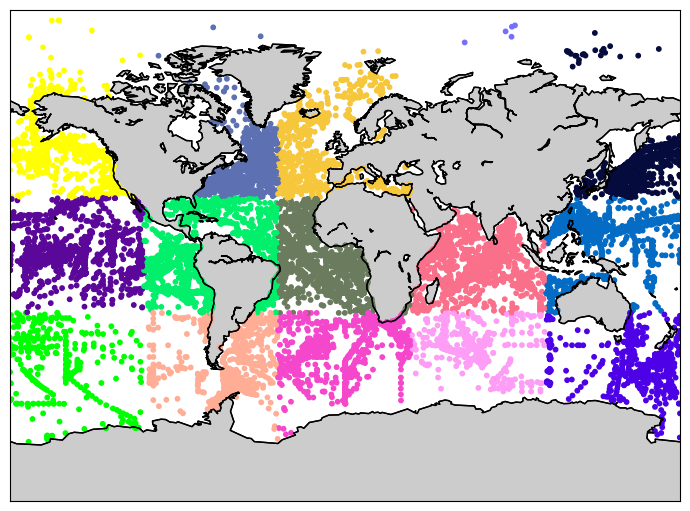

In [13]:
import os
import pandas as pd
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from utils.read_data import get_true_drift_positions

# setting the size of the map
fig = plt.figure(figsize=(7,5.5))

#plt.title('Training Dataset')

# creating the map - setting latitude and longitude
m = Basemap(projection = 'mill', llcrnrlat = -90, urcrnrlat = 90, llcrnrlon = -180, urcrnrlon = 180, resolution = 'c') 

# drawing the coastline
m.drawcoastlines()
#m.drawcountries(color='gray')
# m.drawstates(color='gray')
m.drawcoastlines()
m.fillcontinents()

x, y = m(df_init_pos['lat_init'], df_init_pos['lon_init'])  # transform coordinates
plt.scatter(x, y, 10, marker='o', c=df_init_pos['class'], cmap=custom_cmap) 

plt.tight_layout()
#plt.savefig('figures/training_NOAA.png')
plt.show()

In [14]:
# 50 zones pour train
# 14 zones pour validation
# 8 zones pour test
np.random.seed(4)

a = np.arange(15) # geographical class indices

split1 = int(0.7 * len(a))
split2 = int(0.9 * len(a))

np.random.shuffle(a)

train = a[:split1]
val = a[split1:split2]
test = a[split2:]

print(len(train), len(val), len(test))

10 3 2


In [15]:
def get_train_test_val_info(geoclass):
    if geoclass in train: 
        return 'train'
    if geoclass in val:
        return 'val'
    if geoclass in test:
        return 'test'

In [16]:
df_init_pos['traintestval'] = df_init_pos.apply(lambda row: get_train_test_val_info(row['class']), axis=1)


In [17]:
# get 3 dataframes one for each category: train, test, val

train_df = df_init_pos[df_init_pos['traintestval']=='train']
test_df = df_init_pos[df_init_pos['traintestval']=='test']
val_df = df_init_pos[df_init_pos['traintestval']=='val']


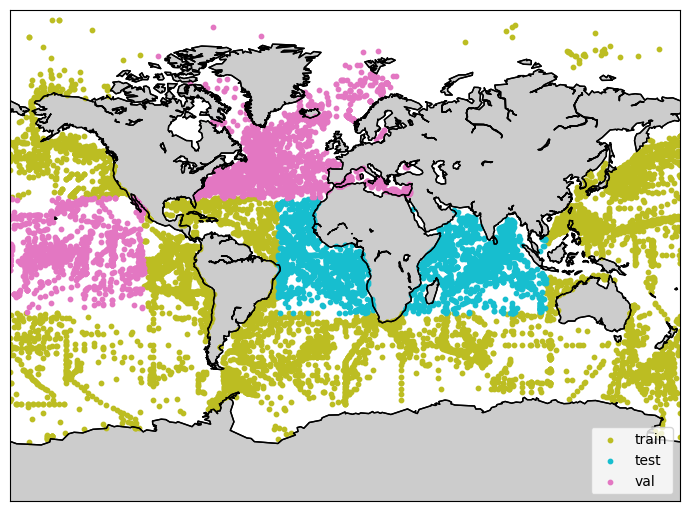

In [18]:
import os
import pandas as pd
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from utils.read_data import get_true_drift_positions

# setting the size of the map
fig = plt.figure(figsize=(7,5.5))

#plt.title('Training Dataset')

# creating the map - setting latitude and longitude
m = Basemap(projection = 'mill', llcrnrlat = -90, urcrnrlat = 90, llcrnrlon = -180, urcrnrlon = 180, resolution = 'c') 

# drawing the coastline
m.drawcoastlines()
#m.drawcountries(color='gray')
# m.drawstates(color='gray')
m.drawcoastlines()
m.fillcontinents()

x, y = m(train_df['lat_init'], train_df['lon_init'])  # transform coordinates
plt.scatter(x, y, 10, marker='o', c='tab:olive', label='train') 
x, y = m(test_df['lat_init'], test_df['lon_init'])  # transform coordinates
plt.scatter(x, y, 10, marker='o', c='tab:cyan', label='test') 
x, y = m(val_df['lat_init'], val_df['lon_init'])  # transform coordinates
plt.scatter(x, y, 10, marker='o', c='tab:pink', label='val') 
plt.legend(loc='lower right')
plt.tight_layout()
#plt.savefig('figures/training_NOAA.png')
plt.show()

In [19]:
train_df.head()

,filename,lat_init,lon_init,hour_init,class,traintestval
2,traj_300234065519400.csv,134.58028,8.55503,162101.0,13,train
4,traj_71456.csv,-103.02417,-32.81879,70712.0,3,train
5,traj_300234066399370.csv,-79.93799,26.28196,167735.0,4,train
8,traj_127146.csv,164.64919,-19.18557,132840.0,13,train
10,traj_89945.csv,-119.55092,79.89985,90484.0,2,train


In [20]:
from utils.read_data import convert_date_back
import math 

np.random.seed(seed = 4)

PATH_TRAJ = '/data/manon/MasterThesis/NOAA/trajectories'

files_train_full = train_df['filename']
files_test_full = test_df['filename']
files_val_full = val_df['filename']

train_files = []
test_files = []
val_files = []

i = 0
while len(train_files)<700:
    i = i + 1
    file = np.random.choice(files_train_full,1)
    file = file[0]

    if file in train_files:
        continue

    data_file = os.path.join(PATH_TRAJ, file)
    #drift_tab = pd.read_csv(data_file)

    df_test = pd.read_csv(data_file)

    lon, lat, hours = get_true_drift_positions(data_file, NOAA=True)

    # check if date is fine
    min_time = min(hours) - 1
    min_date = convert_date_back(min_time)
    if min_date.year < 1995:
        #print('Year not ok: ', min_date.year)
        continue

    # check geographical areas 
    lat_max = math.ceil(max(lat)+1)
    lat_min = math.floor(min(lat)-1)
    lon_max = math.ceil(max(lon)+1)
    lon_min = math.floor(min(lon)-1)

    if not (((lat_max >= 0 and lat_max <= 90) and (lat_min >= 0 and lat_min <= 90)) or ((lat_max >= -90 and lat_max <= 0) and (lat_min >= -90 and lat_min <= 0))):
        #print('Lats not ok: min max lats:', lat_max, lat_min)
        continue

    if not (((lon_max >= -180 and lon_max <= -60) and (lon_min >= -180 and lon_min <= -60)) or ((lon_max >= -60 and lon_max <= 60) and (lon_min >= -60 and lon_min <= 60)) or ((lon_max >= 60 and lon_max <= 180) and (lon_min >= 60 and lon_min <= 180))):
        #print('Lons not ok: min max lons:', lon_max, lon_min)
        continue

    train_files.append(file)

    
print('Total training files tested:', i)

###########################################################################################################

i = 0
while len(test_files)<100:
    i = i + 1
    file = np.random.choice(files_test_full,1)
    file = file[0]

    if file in test_files:
        continue

    data_file = os.path.join(PATH_TRAJ, file)
    #drift_tab = pd.read_csv(data_file)

    lon, lat, hours = get_true_drift_positions(data_file, NOAA=True)

    # check if date is fine
    min_time = min(hours) - 1
    min_date = convert_date_back(min_time)
    if min_date.year < 1995:
        #print('Year not ok: ', min_date.year)
        continue

    # check geographical areas 
    lat_max = math.ceil(max(lat)+1)
    lat_min = math.floor(min(lat)-1)
    lon_max = math.ceil(max(lon)+1)
    lon_min = math.floor(min(lon)-1)

    if not (((lat_max >= 0 and lat_max <= 90) and (lat_min >= 0 and lat_min <= 90)) or ((lat_max >= -90 and lat_max <= 0) and (lat_min >= -90 and lat_min <= 0))):
        #print('Lats not ok: min max lats:', lat_max, lat_min)
        continue

    if not (((lon_max >= -180 and lon_max <= -60) and (lon_min >= -180 and lon_min <= -60)) or ((lon_max >= -60 and lon_max <= 60) and (lon_min >= -60 and lon_min <= 60)) or ((lon_max >= 60 and lon_max <= 180) and (lon_min >= 60 and lon_min <= 180))):
        #print('Lons not ok: min max lons:', lon_max, lon_min)
        continue

    test_files.append(file)

    
print('Total testing files tested:', i)

###############################################################################################################

i = 0
while len(val_files)<200:
    i = i + 1
    file = np.random.choice(files_val_full,1)
    file = file[0]

    if file in val_files:
        continue

    data_file = os.path.join(PATH_TRAJ, file)
    #drift_tab = pd.read_csv(data_file)

    lon, lat, hours = get_true_drift_positions(data_file, NOAA=True)

    # check if date is fine
    min_time = min(hours) - 1
    min_date = convert_date_back(min_time)
    if min_date.year < 1995:
        #print('Year not ok: ', min_date.year)
        continue

    # check geographical areas 
    lat_max = math.ceil(max(lat)+1)
    lat_min = math.floor(min(lat)-1)
    lon_max = math.ceil(max(lon)+1)
    lon_min = math.floor(min(lon)-1)

    if not (((lat_max >= 0 and lat_max <= 90) and (lat_min >= 0 and lat_min <= 90)) or ((lat_max >= -90 and lat_max <= 0) and (lat_min >= -90 and lat_min <= 0))):
        #print('Lats not ok: min max lats:', lat_max, lat_min)
        continue

    if not (((lon_max >= -180 and lon_max <= -60) and (lon_min >= -180 and lon_min <= -60)) or ((lon_max >= -60 and lon_max <= 60) and (lon_min >= -60 and lon_min <= 60)) or ((lon_max >= 60 and lon_max <= 180) and (lon_min >= 60 and lon_min <= 180))):
        #print('Lons not ok: min max lons:', lon_max, lon_min)
        continue

    val_files.append(file)

    
print('Total validation files tested:', i)

Total training files tested: 765
Total testing files tested: 113
Total validation files tested: 228


In [21]:
train_df_short = train_df[train_df['filename'].isin(train_files)]
val_df_short = val_df[val_df['filename'].isin(val_files)]
test_df_short = test_df[test_df['filename'].isin(test_files)]

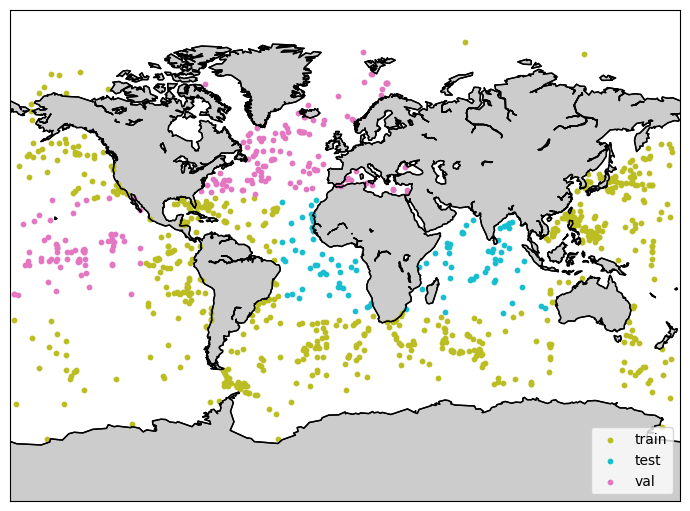

In [22]:
import os
import pandas as pd
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from utils.read_data import get_true_drift_positions

# setting the size of the map
fig = plt.figure(figsize=(7,5.5))

#plt.title('Training Dataset')

# creating the map - setting latitude and longitude
m = Basemap(projection = 'mill', llcrnrlat = -90, urcrnrlat = 90, llcrnrlon = -180, urcrnrlon = 180, resolution = 'c') 

# drawing the coastline
m.drawcoastlines()
#m.drawcountries(color='gray')
# m.drawstates(color='gray')
m.drawcoastlines()
m.fillcontinents()

x, y = m(train_df_short['lat_init'], train_df_short['lon_init'])  # transform coordinates
plt.scatter(x, y, 10, marker='o', c='tab:olive', label='train') 
x, y = m(test_df_short['lat_init'], test_df_short['lon_init'])  # transform coordinates
plt.scatter(x, y, 10, marker='o', c='tab:cyan', label='test') 
x, y = m(val_df_short['lat_init'], val_df_short['lon_init'])  # transform coordinates
plt.scatter(x, y, 10, marker='o', c='tab:pink', label='val') 
plt.legend(loc='lower right')
plt.tight_layout()
#plt.savefig('figures/training_NOAA.png')
plt.show()

In [23]:
import pickle

with open("/data/manon/MasterThesis/NOAA/training_files_1000.pkl", "wb") as fp:   #Pickling
    pickle.dump(list(train_files), fp)
with open("/data/manon/MasterThesis/NOAA/testing_files_1000.pkl", "wb") as fp:   #Pickling
    pickle.dump(list(test_files), fp)
with open("/data/manon/MasterThesis/NOAA/validation_files_1000.pkl", "wb") as fp:   #Pickling
    pickle.dump(list(val_files), fp)